In [ ]:
import nltk
import numpy as np
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

class TextRankSummarizer:
    def __init__(self):
        self.vocab = None
        self.word_index = None
        self.graph = None
        self.scores = None
        self.stopwords = None
        self.tokenizer = RegexpTokenizer(r'\w+')
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, text):
        # Preprocessing
        self.stopwords = set(stopwords.words('english'))
        words = [self.lemmatizer.lemmatize(word.lower()) for word in self.tokenizer.tokenize(text) if word.lower() not in self.stopwords]

        # Build vocabulary and word index
        self.vocab = sorted(list(set(words)))
        self.word_index = {word: i for i, word in enumerate(self.vocab)}

        # Create the adjacency matrix
        n = len(self.vocab)
        self.graph = np.zeros((n, n))
        for sentence in sent_tokenize(text):
            words = [self.lemmatizer.lemmatize(word.lower()) for word in self.tokenizer.tokenize(sentence) if word.lower() not in self.stopwords]
            for i, word1 in enumerate(words):
                if word1 in self.vocab:
                    for j, word2 in enumerate(words):
                        if i != j and word2 in self.vocab:
                            self.graph[self.word_index[word1], self.word_index[word2]] += 1

        # Normalize the adjacency matrix
        degrees = self.graph.sum(axis=0)
        self.graph = np.divide(self.graph, degrees, where=degrees!=0)

        # Calculate the PageRank scores iteratively until convergence
        damping_factor = 0.85
        self.scores = np.ones(n) / n
        while True:
            new_scores = (1 - damping_factor) / n + damping_factor * self.graph.dot(self.scores)
            if np.linalg.norm(self.scores - new_scores) < 1e-5:
                break
            self.scores = new_scores

    def transform(self, text, n):
        # Calculate sentence scores based on the average of the word scores in each sentence
        sentence_scores = np.zeros(len(sent_tokenize(text)))
        for i, sentence in enumerate(sent_tokenize(text)):
            words = [self.lemmatizer.lemmatize(word.lower()) for word in self.tokenizer.tokenize(sentence) if word.lower() not in self.stopwords]
            indices = [self.word_index[word] for word in words if word in self.word_index]
            if len(indices) > 0:
                sentence_scores[i] = self.scores[indices].mean()

        # Get the top n sentences
        top_indices = sentence_scores.argsort()[-n:]
        top_indices.sort()
        summary = ' '.join([sent_tokenize(text)[i] for i in top_indices])
        return summary


In [ ]:
# Import the TextRankSummarizer class
#from textrank import TextRankSummarizer

# Create a TextRankSummarizer object
summarizer = TextRankSummarizer()
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Fit the TextRankSummarizer object to a piece of text
text = '''Steven Spielberg sent a letter to express his enjoyment of the Netflix show Mo, making its lead star emotional. 
Premiering in August of last year, the single-camera comedy centers around Mohammed Amer as a fictionalized version of himself. 
The actor and comedian portrays Mo Najjar, a Palestinian refugee who constantly seems just one step away from obtaining asylum in the U.S. 
Najjar lives with his family in Houston, Texas, and, \
across eight episodes, Najjar hilariously adjusts to wild circumstances even as he faces some very specific struggles.
In a conversation with Entertainment Weekly, Amer discussed the series and reflected on his past interactions with Spielberg. 
In the quote below, Amer talks about sitting across from the legendary director and gets emotional while recalling Spielberg's support.
 Amer specifically mentions that the Jurassic Park helmer sent him a letter to express his enjoyment of Mo, which has been renewed for season 2:
Getting honored by the American Film Institute was the first—like, whoa. You think… to be sitting across James Cameron and Spielberg, that was just crazy to me. 
And I was sitting there talking to [Slovan] “Slick” [Naim], our director. I think we were sitting there and he’s—because nobody’s ever filmed a show in Houston. 
They were, like, literally trying to talk him into filming in their barber shop and then a year later we’re sitting there getting a letter from Spielberg about how much he enjoyed the show.
It just brings tears to your eyes. Like, literally, it just makes it all so worth it. 
All that pain and all that struggle to get the show off the ground, and of course, to get a Peabody nomination is huge. 
I’m very, very excited about it and honored, of course, and just tip my hat to the entire production team. Everybody’s efforts were the reason why we ended up getting this nomination.
Just as Amer mentions in his comments, Mo has racked up several accolades and nominations.
 The series has a perfect score on Rotten Tomatoes and it also won the Gotham Award for Breakthrough Series. 
 Mo was also named TV Program of the Year at this year's AFI Awards, while also being nominated by the Film Independent Spirit Awards and the Peabody Awards.
digitalmarketinginstitute.com/us/courses
The series, which also stars Farah Bsieso, Omar Elba, Teresa Ruiz, and Tobe Nwigwe, is praised on the basis of its diversity and the respective it highlights. 
The show brings focus to the life of a Palestinian refugee, something that's rarely seen in the media. But it's also important to note that Mo is genuinely entertaining as well. 
While a lot of half-hour programs on streaming lean more toward drama, the writing team knows to keep humor at the center of the narrative in spectacular ways.

'''
summarizer.fit(text)

# Get a summary of the text
summary = summarizer.transform(text, n=2)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
print(summary)

Steven Spielberg sent a letter to express his enjoyment of the Netflix show Mo, making its lead star emotional. Mo was also named TV Program of the Year at this year's AFI Awards, while also being nominated by the Film Independent Spirit Awards and the Peabody Awards.


In [ ]:
def visualize_summary(article, summary, color='yellow', alignment='center'):
    # Find the starting and ending indices of the summary in the article
    start_index = article.find(summary)
    end_index = start_index + len(summary)

    # Generate the highlighted article using ANSI escape codes
    if color == 'yellow':
        color_code = '\033[43m'  # ANSI escape code for yellow background
    else:
        color_code = '\033[0m'  # No color
    highlighted_article = article[:start_index] + color_code + '\033[1m' + summary + '\033[0m' + article[end_index:]

    # Print the highlighted article with alignment
    if alignment == 'left':
        print('\n\033[1mOriginal-Text:\033[0m\n',highlighted_article)
    elif alignment == 'center':
        print('\n\033[1mOriginal-Text:\033[0m\n',highlighted_article.center(80))
    elif alignment == 'right':
        print('\n\033[1mOriginal-Text:\033[0m\n',highlighted_article.rjust(80))
    else:
        print('\n\033[1mOriginal-Text:\033[0m\n', highlighted_article)

# Example usage
summary = summarizer.transform(text, n=3)
visualize_summary(text, summary, color='yellow', alignment='center')
print('\n\033[1mSummary:\033[0m\n', summary)


Original-Text:
 Steven Spielberg sent a letter to express his enjoyment of the Netflix show Mo, making its lead star emotional. 
Premiering in August of last year, the single-camera comedy centers around Mohammed Amer as a fictionalized version of himself. 
The actor and comedian portrays Mo Najjar, a Palestinian refugee who constantly seems just one step away from obtaining asylum in the U.S. 
Najjar lives with his family in Houston, Texas, and, across eight episodes, Najjar hilariously adjusts to wild circumstances even as he faces some very specific struggles.
In a conversation with Entertainment Weekly, Amer discussed the series and reflected on his past interactions with Spielberg. 
In the quote below, Amer talks about sitting across from the legendary director and gets emotional while recalling Spielberg's support.
 Amer specifically mentions that the Jurassic Park helmer sent him a letter to express his enjoyment of Mo, which has been renewed for season 2:
Getting honored by th

In [ ]:
from collections import Counter

def get_ngrams(text, n):
    """Extracts n-grams from a text"""
    return Counter(zip(*[text[i:] for i in range(n)]))

def calculate_rouge(text1, text2, n):
    """Calculates ROUGE score between two texts for a given n-gram length"""
    ngrams1 = get_ngrams(text1, n)
    ngrams2 = get_ngrams(text2, n)
    overlap = sum((ngrams1 & ngrams2).values())
    rouge = overlap / len(ngrams1) if len(ngrams1) > 0 else 0.0
    return rouge

# Example usage
reference = text
generated = summary
rouge_1_score = calculate_rouge(reference, generated, 1)
rouge_2_score = calculate_rouge(reference, generated, 2)
rouge_3_score = calculate_rouge(reference, generated, 3)
rouge_4_score = calculate_rouge(reference, generated, 4)
print("ROUGE-1 score:", rouge_1_score)
print("ROUGE-2 score:", rouge_2_score)
print("ROUGE-3 score:", rouge_3_score)
print("ROUGE-4 score:", rouge_4_score)


ROUGE-1 score: 7.26984126984127
ROUGE-2 score: 1.04337899543379
ROUGE-3 score: 0.3647342995169082
ROUGE-4 score: 0.24337479718766902


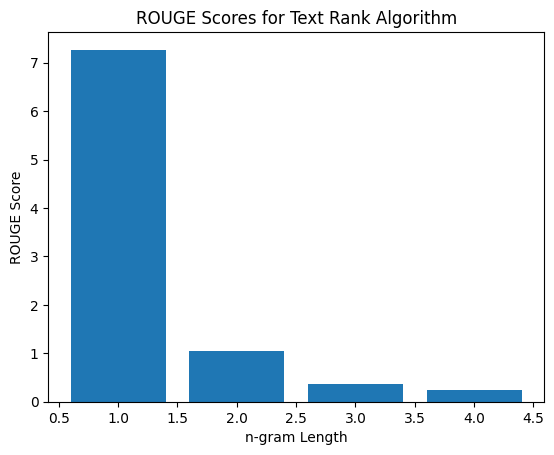

In [ ]:
import matplotlib.pyplot as plt

# Calculate the ROUGE scores for each generated summary
rouge_1_score = calculate_rouge(reference, generated, 1)
rouge_2_score = calculate_rouge(reference, generated, 2)
rouge_3_score = calculate_rouge(reference, generated, 3)
rouge_4_score = calculate_rouge(reference, generated, 4)

# Create a list of the ROUGE scores and their corresponding n-gram lengths
rouge_scores = [rouge_1_score, rouge_2_score, rouge_3_score, rouge_4_score]
n_gram_lengths = [1, 2, 3, 4]

# Create a list of the ROUGE scores and their corresponding n-gram lengths
rouge_scores = [rouge_1_score, rouge_2_score, rouge_3_score, rouge_4_score]
n_gram_lengths = [1, 2, 3, 4]

# Plot the ROUGE scores as a bar plot
plt.bar(n_gram_lengths, rouge_scores)
plt.xlabel("n-gram Length")
plt.ylabel("ROUGE Score")
plt.title("ROUGE Scores for Text Rank Algorithm")
plt.show()
